In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
#data = pd.read_csv("/content/gdrive/My Drive/已存在google雲端的檔名")

Mounted at /content/gdrive


In [6]:
data_raw = pd.read_csv("/content/gdrive/My Drive/Course/Colab Notebooks/training_1600000.csv",encoding = "ISO-8859-1", header=None)

In [7]:
# As the data has no column titles, we will add our own
data_raw.columns = ["sentiment", "time", "date", "query", "username", "text"]

# Show the first 5 rows of the dataframe.
# You can specify the number of rows to be shown as follows: df_raw.head(10)
data_raw.head()

,sentiment,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
data_raw = data_raw.drop(["time", "date", "query", "username"], axis=1)
data_raw['sentiment'] = data_raw['sentiment'].replace(4,1)
data_raw.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
# split a sample dataset, using smaller csv to train first
drop_item=data_raw.sample(frac=0.5,random_state=200) #random state is a seed value
dataset=data_raw.drop(drop_item.index)

In [10]:
dataset['sentiment'].value_counts()

1    400239
0    399761
Name: sentiment, dtype: int64

## Preprocess the text

In [11]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('/content/gdrive/My Drive/Course/Colab Notebooks/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    # Replace #Hashtags to '<hashtags>'.
    tweet = re.sub(userPattern,'<hashtag>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [12]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 41.6 s, sys: 84.6 ms, total: 41.6 s
Wall time: 41.7 s


### Split the dataset

In [13]:
from sklearn.model_selection import train_test_split

X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [14]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [15]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

2020-12-02 10:25:39,971 : INFO : collecting all words and their counts
2020-12-02 10:25:39,972 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-02 10:25:40,008 : INFO : PROGRESS: at sentence #10000, processed 136043 words, keeping 13479 word types
2020-12-02 10:25:40,038 : INFO : PROGRESS: at sentence #20000, processed 272741 words, keeping 20567 word types
2020-12-02 10:25:40,071 : INFO : PROGRESS: at sentence #30000, processed 409776 words, keeping 26350 word types
2020-12-02 10:25:40,103 : INFO : PROGRESS: at sentence #40000, processed 545191 words, keeping 30997 word types
2020-12-02 10:25:40,133 : INFO : PROGRESS: at sentence #50000, processed 681953 words, keeping 35315 word types
2020-12-02 10:25:40,167 : INFO : PROGRESS: at sentence #60000, processed 818062 words, keeping 39214 word types
2020-12-02 10:25:40,204 : INFO : PROGRESS: at sentence #70000, processed 954447 words, keeping 42850 word types
2020-12-02 10:25:40,236 : INFO : PROGRESS: at 

Vocabulary Length: 34851
CPU times: user 2min 11s, sys: 705 ms, total: 2min 12s
Wall time: 1min 12s


## Tokenize and Padding

In [16]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 180233


In [18]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (760000, 60)
X_test.shape : (40000, 60)


## Create Embedding matrix

In [19]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (180233, 100)


## Create Model

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [21]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [22]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           18023300  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

### Callbacks and Earlystop

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Compile

In [24]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train

In [25]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
668/668 [==============================] - 80s 120ms/step - loss: 0.4551 - accuracy: 0.7837 - val_loss: 0.4185 - val_accuracy: 0.8073
Epoch 2/12
668/668 [==============================] - 82s 122ms/step - loss: 0.4165 - accuracy: 0.8067 - val_loss: 0.3943 - val_accuracy: 0.8190
Epoch 3/12
668/668 [==============================] - 84s 125ms/step - loss: 0.4025 - accuracy: 0.8150 - val_loss: 0.3864 - val_accuracy: 0.8244
Epoch 4/12
668/668 [==============================] - 84s 126ms/step - loss: 0.3936 - accuracy: 0.8201 - val_loss: 0.3812 - val_accuracy: 0.8283
Epoch 5/12
668/668 [==============================] - 84s 126ms/step - loss: 0.3873 - accuracy: 0.8233 - val_loss: 0.3770 - val_accuracy: 0.8308
Epoch 6/12
668/668 [==============================] - 84s 126ms/step - loss: 0.3819 - accuracy: 0.8259 - val_loss: 0.3754 - val_accuracy: 0.8322
Epoch 7/12
668/668 [==============================] - 84s 126ms/step - loss: 0.3779 - accuracy: 0.8285 - val_loss: 0.3755 - val_ac

## Evaluate the model

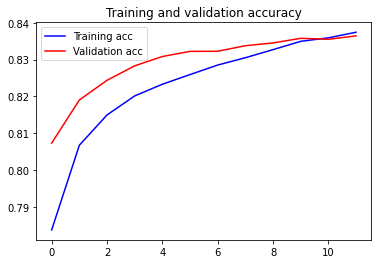

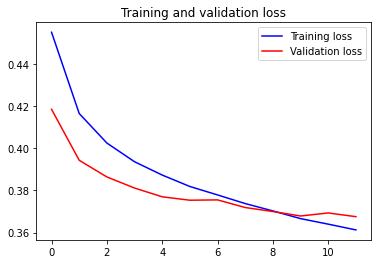

In [34]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("/content/gdrive/My Drive/Course/Colab Notebooks/training_process_acc.png", dpi =300)

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()



plt.savefig("/content/gdrive/My Drive/Course/Colab Notebooks/training_process_loss.png", dpi =300)
plt.show()

## Confusion matrix

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig("/content/gdrive/My Drive/Course/Colab Notebooks/conf_matrix.png", dpi =300)

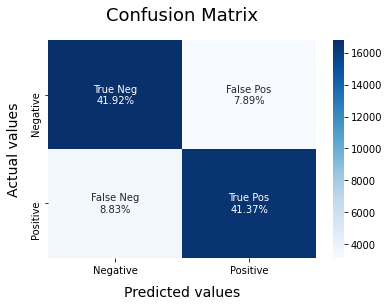

In [36]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [42]:
%%time
# evaluate
score = training_model.evaluate(X_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40/40 [==============================] - 2s 42ms/step - loss: 0.3724 - accuracy: 0.8328

ACCURACY: 0.8328499794006348
LOSS: 0.37242159247398376
CPU times: user 706 ms, sys: 94.6 ms, total: 801 ms
Wall time: 1.79 s


## Saving the model

In [37]:
word2vec_model.wv.save('/content/gdrive/My Drive/Course/Colab Notebooks/Word2Vec-twitter-100-dims.model')
word2vec_model.wv.save_word2vec_format('/content/gdrive/My Drive/Course/Colab Notebooks/Word2Vec-twitter-100-dims-trainable.model')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the BiLSTM-Model.
training_model.save('/content/gdrive/My Drive/Course/Colab Notebooks/BiLSTM_gensim_0836_12epo.h5')

2020-12-02 11:14:39,828 : INFO : saving Word2VecKeyedVectors object under /content/gdrive/My Drive/Course/Colab Notebooks/Word2Vec-twitter-100-dims.model, separately None
2020-12-02 11:14:39,830 : INFO : not storing attribute vectors_norm
2020-12-02 11:14:40,082 : INFO : saved /content/gdrive/My Drive/Course/Colab Notebooks/Word2Vec-twitter-100-dims.model
2020-12-02 11:14:40,083 : INFO : storing 34851x100 projection weights into /content/gdrive/My Drive/Course/Colab Notebooks/Word2Vec-twitter-100-dims-trainable.model


## try predict

In [38]:
model = training_model
def predict(text):
    
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=60)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    #label = -1 if score < 0.5 else 1
    out_score = round(float(score),4)

    return out_score

In [39]:
predict("I love u so much")

0.7858

In [41]:
predict("I'm going under and this time I fear there's no one to save me")

0.0186